# Исследование триггеров и целевых действий

#### Условие задачи

Дан - набор триггеров (triggers.csv) и набор целевых действий (actions.csv)

На основании триггеров было осуществлено взаимодействие с некоторыми абонентами. В качестве успешного статуса взаимодействия служит файл actions.csv.

#### Описание  датасета

actions.csv

- guid - идентификатор пользователя
- date - дата взаимодействия с пользователем
- result - 0 если пользователь нет заинтересовался предложением, 1 иначе

triggers.csv

- guid - идентификатор пользователя
- date - дата триггера
- trigger - идентификатор триггера
- type - тип взаимодействия с пользователем

#### Ограничение: 

- нельзя взаимодействовать с пользователем чаще чем один раз в две недели.

#### Цель: 

- построить модель взаимодействия с пользователями которая покажет в проде прирост по количеству результативних действий по сравнению с текущей стратегией.

#### Результат: 

- краткое описание подхода к решению задачи и его обоснование, 
- код по обучению и инференсу модели.

## Сформулирую задачи, исходя из общей цели:

- разработать и обучить модель бинарной классификации для прогнозирования успешного статуса взаимодействия с пользователем  

#### Общая идея решения задачи такая, хотя она нуждается в детальной проработке:

- На первом этапе разрабатывается и обучается модель. Процесс разработки описан ниже. 

- После обучения, модель используется для проверки целесообразности направления предложения.  Перед отправкой предложения пользователю вектор с параметрами (guid,date,trigger,type) направляется в модель. Если модель возвращает 1, то это означает, что модель прогнозирует успешное целевое действие, после чего предложение направляется пользователю. Если модель вернула 0, то меняется тип триггера и процесс повторяется пока типы триггеров не закончатся. Если все типы триггеров вернули 0, то этот пользовательский вектор откладывается в очередь неудач (либо таблица неудач в БД) и тестируется следующий пользователь. Те пользователи, которым были направлены предложения помещаются в отдельную таблицу БД, где записана guid пользователя и дата успеха. Каждый пользователь из таблицы успеха обрабатывается 1 раз в 2 недели. Пользователи из таблицы неудачь обрабатываются чаще, например 1 раз в день (или как-то по другому). 

- Ещё один важный вопрос: по какому алгоритму выбирать пользователей для тестирования в модели? У нас есть 3 таблицы в БД. Основная таблица, где хранятся все пользователи, таблица успехов и таблица неудач. Для решения этой задачи  понадобится реализация приоритетов обработки таблиц БД. Наиболее важный приоритет имеет таблица с успехами, средний приоритет имеет общая таблица пользователей, самый низкий приоритет имеет таблица неудач. 

Как-то так я бы решил поставленную задачу. 



## План разработки и обучения модели:

- исследовать данные и найти общие закономерности
- выполнить ресемплирование данных по единице времени (скорее всего неделями, но я ещё не смотрел данные)
- построить синтетические признаки для задачи классификации
- обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 25% от исходных данных.
- Проверить данные на тестовой выборке
        

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import time
from scipy import stats as st

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (
    make_column_selector,
    make_column_transformer,
    ColumnTransformer,
)

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# задаем повторяющуюся генерацию псевдослучайные величины на весь проект
RANDOM_STATE = 14082024

In [3]:
triggers=pd.read_csv('triggers.csv', sep=',', decimal = ',', parse_dates=['date'])
actions=pd.read_csv('actions.csv', sep=',', decimal = ',', parse_dates=['date'])

### Проведем загрузку данных и разведочный анализ

In [4]:
display(triggers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43074627 entries, 0 to 43074626
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   guid     object        
 1   date     datetime64[ns]
 2   trigger  int64         
 3   type     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.3+ GB


None

In [5]:
display(triggers.tail())

,guid,date,trigger,type
43074622,018eef87-6338-d8f4-f64e-44e78640914f,2024-05-01 00:03:38,1797,2
43074623,0187a472-d58b-0e0e-b83e-f11bc81df9ce,2024-05-01 00:03:38,2603,2
43074624,0187a472-d58b-0e0e-b83e-f11bc81df9ce,2024-05-01 00:03:38,2603,2
43074625,018da04f-90fd-1627-1620-2c6f247f1287,2024-05-01 00:03:38,2065,2
43074626,018c3f3b-24d4-4f01-1166-74acaa01f13a,2024-05-01 00:03:38,1805,2


In [6]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378204 entries, 0 to 378203
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   guid    378204 non-null  object        
 1   date    378204 non-null  datetime64[ns]
 2   result  378204 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.7+ MB


In [7]:
display(actions.tail())

,guid,date,result
378199,018ba19f-0ac4-ba30-e2d4-cfd696105d47,2024-05-04 08:18:31,0
378200,0187a474-1960-77e4-3a59-2ece1d0487c7,2024-05-08 04:43:05,0
378201,0187a471-185a-6d7e-ec32-49cb25a365a7,2024-05-01 10:57:16,0
378202,0187a13b-2dba-5726-6baa-cbcad7ad74e6,2024-05-15 10:35:57,0
378203,0187a474-ad1d-0188-6f08-ed85aefabfb0,2024-05-29 11:29:26,0


#### Проверим данные на пропуски

In [8]:
print(triggers.isnull().sum())
print('--------------')
print(actions.isnull().sum())
print('--------------')

guid       0
date       0
trigger    0
type       0
dtype: int64
--------------
guid      0
date      0
result    0
dtype: int64
--------------


#### Перед проверкой на дубликаты заменим все буквы в словах на строчные

In [9]:
# функция по уменьшению букв
def df_lower(df, lower_list):
    for value in lower_list:
        df[value]=df[value].str.lower()
    
# создадим списки, где надоуменьшить буквы и уменьшим их 
lower_list=['guid']

df_lower(triggers,lower_list)
df_lower(actions, lower_list)

In [10]:
print(triggers.duplicated().sum())
print('--------------')
print(actions.duplicated().sum())
print('--------------')

5933568
--------------
0
--------------


#### В датасете triggers обнаружено 5933568 строк дубликатов, которые необходимо удалить

In [11]:
# удалим дубликаты и обновим индексацию
triggers.drop_duplicates(inplace=True)
actions.drop_duplicates(inplace=True)

print(triggers.duplicated().sum())
print('--------------')
print(actions.duplicated().sum())
print('--------------')

0
--------------
0
--------------


In [12]:
display(len(triggers))

37141059

In [13]:
triggers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37141059 entries, 0 to 43074626
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   guid     object        
 1   date     datetime64[ns]
 2   trigger  int64         
 3   type     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.4+ GB


#### Выводы

- все буквы заменены на строчные
- типы столбцов преобразованы.
- проверено наличие пропущенных значений.
- удалены дубликаты

### Рассмотрим признаки

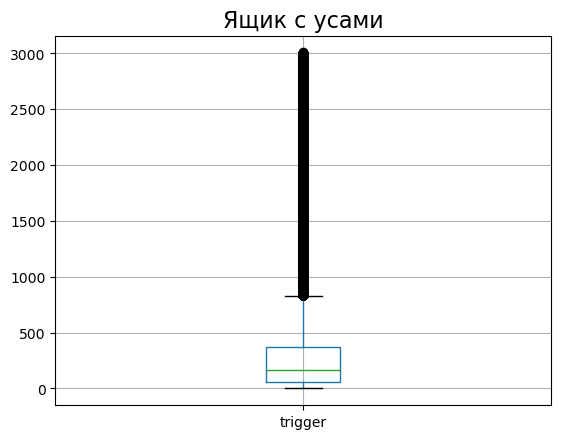

In [14]:
# Рассмотрим колонку triggers постром boxplot
triggers.boxplot(column='trigger')
plt.title('Ящик с усами', fontsize=16)
plt.show()

#### Что происходит? Пока не понятно. Очевидно, что это не распределение Гаусса

In [15]:
# найдём максимальное и минимальное значение в triggers

print(triggers.trigger.min())
print('--------------')
print(triggers.trigger.max())
print('--------------')

0
--------------
3008
--------------


In [16]:
# Функция построения гистограмм с нанесенной медианой и средним
def hist_visio(df_ser, names, y_lim, bins):
    bins = bins # создаем массив бинов, где каждый бин - это целое число от 0 до максимального значения в датафрейме
    plt.hist(df_ser, bins=bins) # строим гистограмму
    plt.title(names[0], fontsize=16)
    plt.xlabel(names[1], fontsize=16)
    plt.ylabel(names[2], fontsize=16)
    median = df_ser.median()
    mean = df_ser.mean()
    plt.axvline(median, color='red', linestyle='-')
    plt.axvline(mean, color='green', linestyle='-')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlim(min(df_ser), max(df_ser))
    plt.legend(['Медиана', 'Среднее'], loc='upper left')
    plt.show()

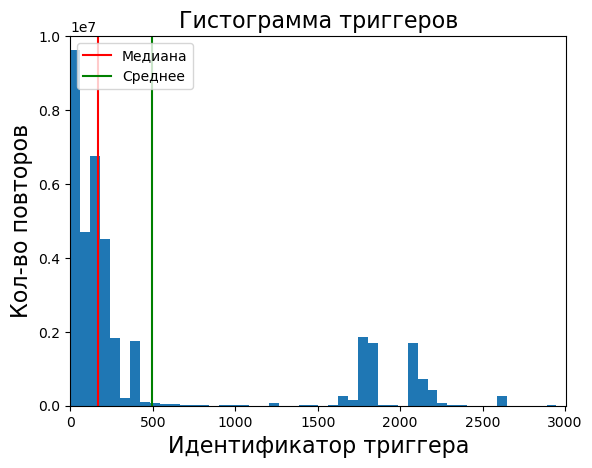

In [17]:
names_triggers=['Гистограмма триггеров', 'Идентификатор триггера', 'Кол-во повторов']
y_lim_triggers=[0, 10000000]
hist_visio(triggers['trigger'], names_triggers, y_lim_triggers, 50)

#### Идентификатор триггера описывается композицией распределениями, в т.ч. показательным и два горба между значением 1500 и 2500. 

### Рассмотрим колонку type в датасете triggers

In [18]:
# выведем количесво уникальных значений в колонке triggers
print(triggers.type.nunique())
print('----------------')
print(triggers['type'].unique())

3
----------------
[2 3 1]


#### В колонке type датасета triggers всего 3 уникальных значения. 

- На гистограмме триггеров явно наблюдается показательное расспределение с двумя горбами. Колонка идентификатор триггера описыват три несвязанных друг с другом процесса. Все эти процессы объединены в одну абстрактную колонку. Вероятно композия распределений обусловлена данным обстоятельством. 

### Рассмотрим колонку date таблицы triggers и actions

In [19]:
#  Установим индекс таблицы, равным столбцу Datetime
triggers_date=triggers.set_index('date')
actions_date=actions.set_index('date')

In [20]:
triggers_date.head()

,guid,trigger,type
date,,,
2024-05-31 23:55:27,018bdd75-83fc-2510-50e7-153f7b5e4b64,2047,2
2024-05-31 23:55:27,0187a472-becb-7994-5e1e-f179b60bc141,168,2
2024-05-31 23:55:26,018ba175-9e02-8c7a-e522-6e5fec6949a0,1807,2
2024-05-31 23:55:26,018ba175-9e02-8c7a-e522-6e5fec6949a0,2048,2
2024-05-31 23:55:26,018e9cfb-c8bc-f38b-e209-5a77c5324a14,1773,2


In [21]:
actions_date.head()

,guid,result
date,,
2024-05-20 08:28:13,0187a45c-6784-7e2f-5d84-f3c89dee6a60,0
2024-05-31 08:19:10,0187a45d-650b-4a4f-ea59-9432556c9b1d,0
2024-05-13 09:01:37,018ba1bd-3c62-0269-e77f-655655f10b3e,0
2024-05-22 05:18:46,018efb50-1738-e3af-58e8-0550e9a272ca,0
2024-05-10 16:18:53,0187a45c-7aa1-3ec6-3c68-c86cb9172299,0


#### Проверим, в хронологическом ли порядке расположены даты и время?

In [22]:
triggers_date.sort_index(inplace=True, ascending=True)
print(triggers_date.index.is_monotonic)

True


In [23]:
actions_date.sort_index(inplace=True, ascending=True)
print(actions_date.index.is_monotonic)

True


#### Построим график с разбивкой по часу date из triggers

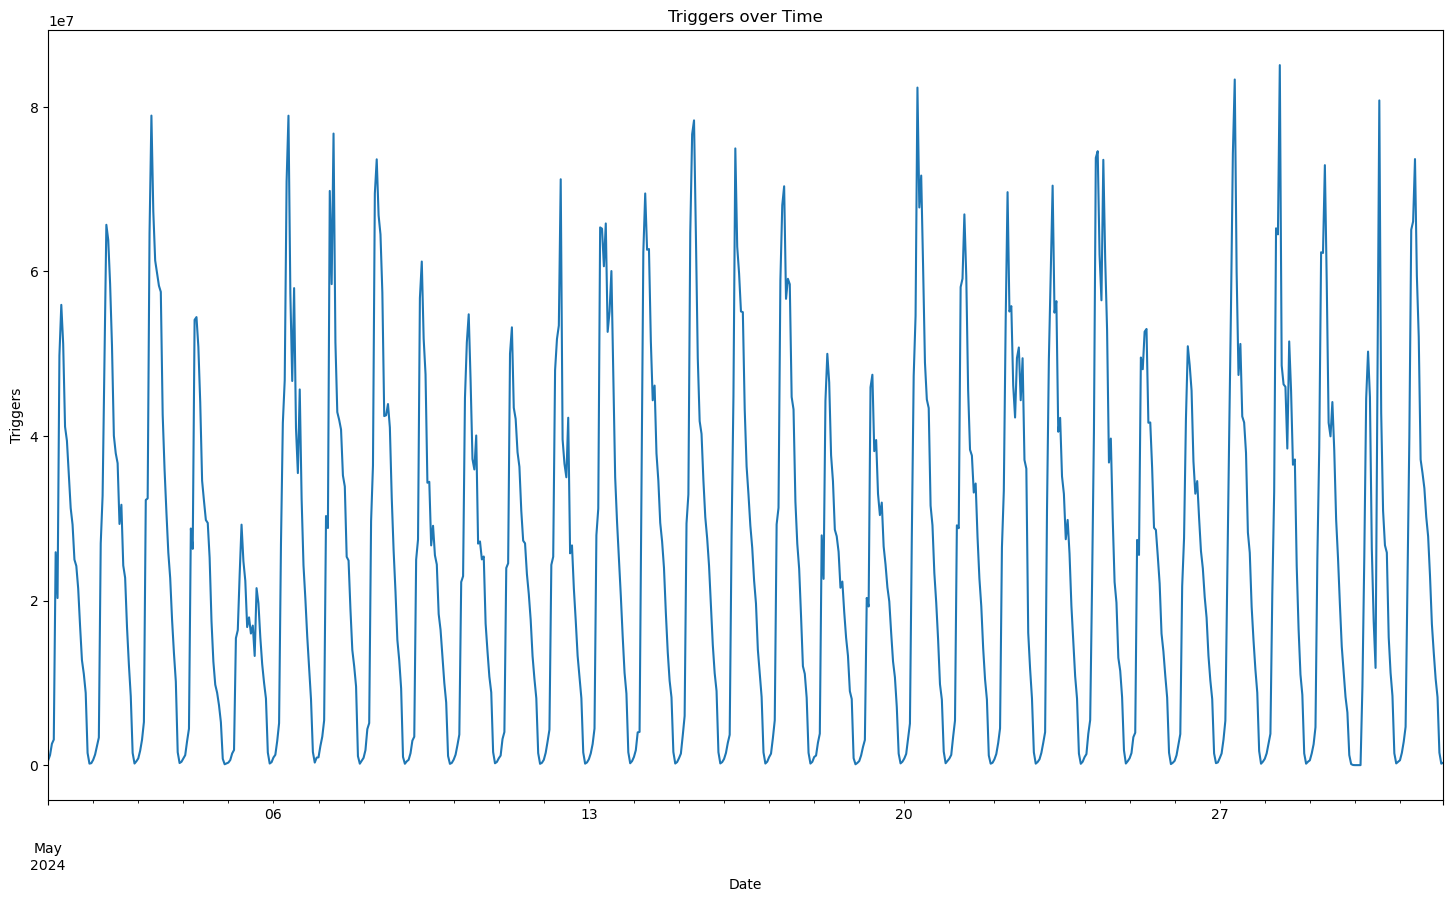

In [24]:
triggers_date = triggers_date.resample('1H').sum()
figsize = (18,10)

triggers_date['trigger'].plot(figsize=figsize)
plt.xlabel('Date')
plt.ylabel('Triggers')
plt.title('Triggers over Time')
plt.show()

### Сразу бросается в глаза закономерность - минимальное количество "идентификатора триггера" наблюдается воскресенье и понедельник.  

#### Слишком много данных, рассмотрим меньший интервал

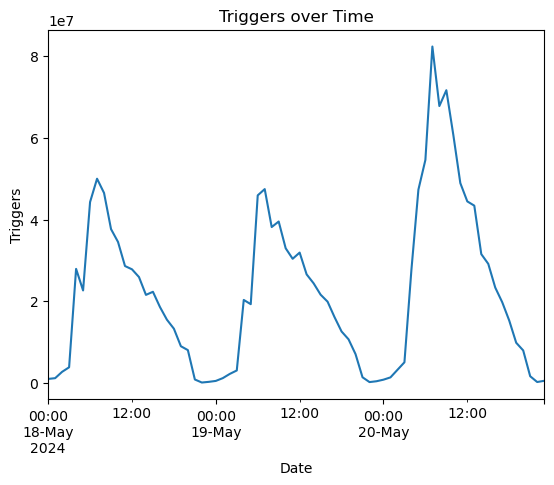

In [25]:
triggers_date['trigger']['2024-05-18':'2024-05-20'].plot()
plt.xlabel('Date')
plt.ylabel('Triggers')
plt.title('Triggers over Time')
plt.show()

#### Максимальное количество "идентификатора триггера" наблюдается в утренние часы

## Проверим колонку result из таблицы actions на корректные значения 

In [26]:
# выведем количество уникальных значений в колонке result
print(actions_date.result.nunique())
print('----------------')
print(actions_date['result'].unique())

2
----------------
[0 1]


In [27]:
actions_date = actions_date.resample('1H').sum()
figsize = (18,10)

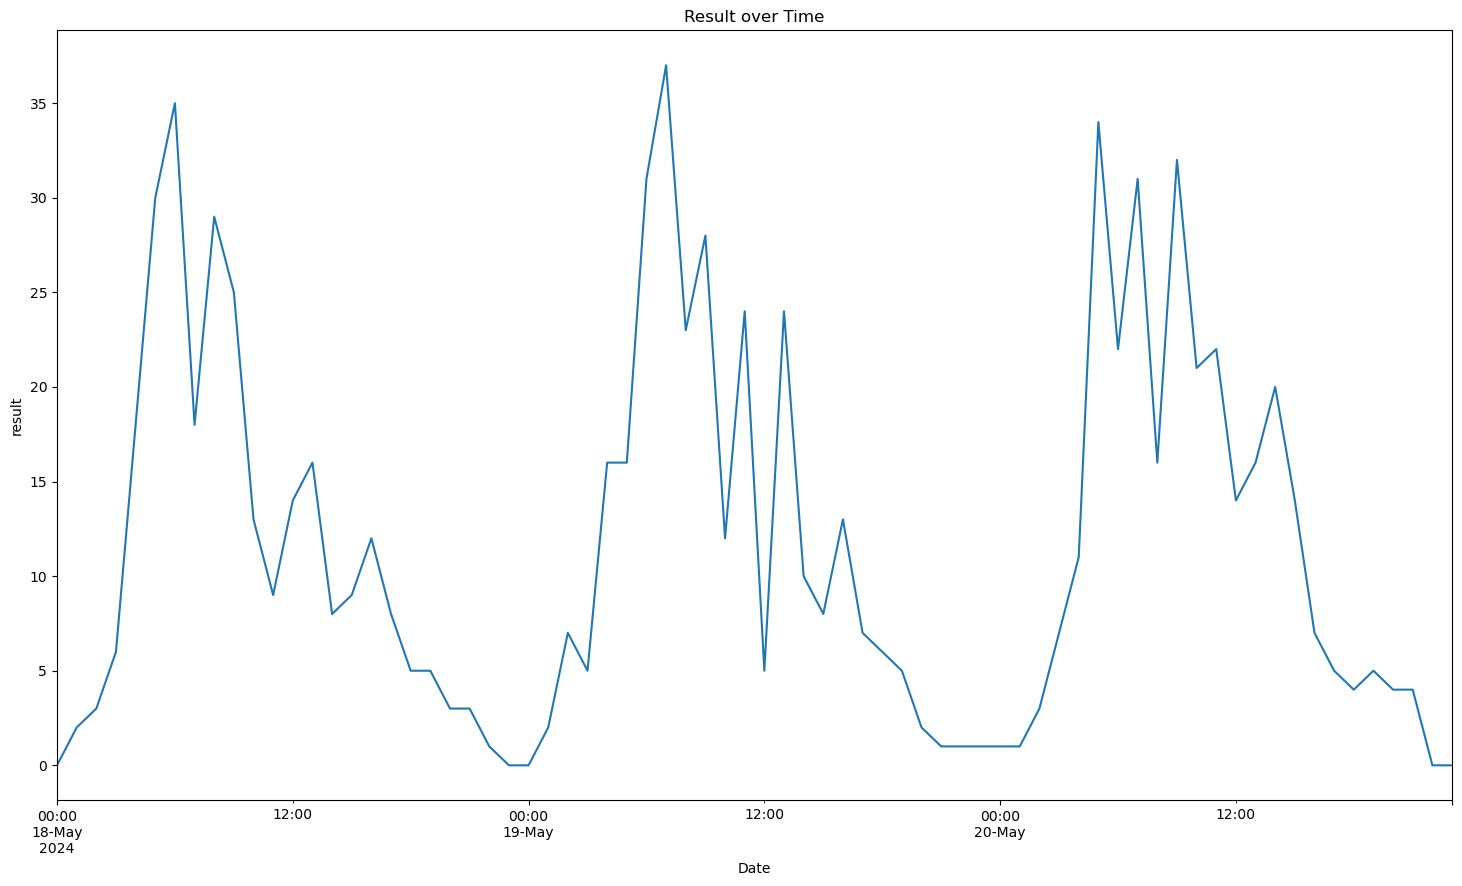

In [28]:
actions_date['result']['2024-05-18':'2024-05-20'].plot(figsize=figsize)
plt.xlabel('Date')
plt.ylabel('result')
plt.title('Result over Time')
plt.show()

### Выводы:

- Наблюдается очевидная связь между количеством направленных попыток взаимодейства и успешных взаимодействий. Чем больше общих попыток, тем больше успешных взаимодействий. Пик успехов соответствует пику общих попыток.

## Объединим таблицы по guid и проведем исследовательский анализ

In [29]:
df = pd.merge(triggers, actions, on='guid', how='outer')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55161456 entries, 0 to 55161455
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   guid     object        
 1   date_x   datetime64[ns]
 2   trigger  int64         
 3   type     int64         
 4   date_y   datetime64[ns]
 5   result   float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.9+ GB


In [31]:
df.head()

,guid,date_x,trigger,type,date_y,result
0,018bdd75-83fc-2510-50e7-153f7b5e4b64,2024-05-31 23:55:27,2047,2,NaT,NaN
1,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-31 23:55:27,168,2,2024-05-17 12:19:25,0.0
2,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-20 05:07:04,2074,2,2024-05-17 12:19:25,0.0
3,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-17 12:25:37,1773,2,2024-05-17 12:19:25,0.0
4,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-17 12:15:34,1773,2,2024-05-17 12:19:25,0.0


#### Тип колонки result изменился на float из за того, что в строках появились значения Nan. Для устранения этой проблемы, удалим все строки, содержащие Nan в колонке result

In [32]:
print(df.isnull().sum())
print('--------------')
print(df.duplicated().sum())
print('--------------')

guid              0
date_x            0
trigger           0
type              0
date_y     12501649
result     12501649
dtype: int64
--------------
0
--------------


In [33]:
df = df.dropna()

In [34]:
df.head()

,guid,date_x,trigger,type,date_y,result
1,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-31 23:55:27,168,2,2024-05-17 12:19:25,0.0
2,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-20 05:07:04,2074,2,2024-05-17 12:19:25,0.0
3,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-17 12:25:37,1773,2,2024-05-17 12:19:25,0.0
4,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-17 12:15:34,1773,2,2024-05-17 12:19:25,0.0
5,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,1807,2,2024-05-28 01:41:41,0.0


#### Теперь вернём тип int64 колонке result

In [35]:
df['result'] = df['result'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42659807 entries, 1 to 55161446
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   guid     object        
 1   date_x   datetime64[ns]
 2   trigger  int64         
 3   type     int64         
 4   date_y   datetime64[ns]
 5   result   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 2.2+ GB


In [36]:
# Переименовываем колонки
df = df.rename(columns={'date_x': 'date_trigger', 'date_y': 'date_result'})
df.head()

,guid,date_trigger,trigger,type,date_result,result
1,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-31 23:55:27,168,2,2024-05-17 12:19:25,0
2,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-20 05:07:04,2074,2,2024-05-17 12:19:25,0
3,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-17 12:25:37,1773,2,2024-05-17 12:19:25,0
4,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-17 12:15:34,1773,2,2024-05-17 12:19:25,0
5,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,1807,2,2024-05-28 01:41:41,0


<div style="border:solid Chocolate 2px; padding: 40px">
<h2> Синтетические признаки </h2>

- Применение данных для решения задачи класификации затруднено, потому что они не универсальны. Колонки date_trigger и date_result содержат прошедшие дату и время. Такая комбинация даты и времени больше никода не повторится. Также есть столбец guid, который съедает много памяти и не несёт смысловую нагрузку.  

- Поэтому для модели наличие этих столбцов не имеют никакого смысла, но в них скрыта информация, которая может помочь в решении задачи.    

- На основе "ненужных" столбцов мы можем сформировать синтенические признаки, которые сохранят информацию, но не будут перегружать модель.

- Вариантов синтетических данных может быть огромное количество. Для решения задачи создадим два признака:

- Синтетический признак "ожидание", который равен разности между датой триггера и датой достжения результата;
- Поскольку у одного guid может быть несколько результативних действий, добавим признак "увлеченность", который будет характеризовать количество результативних действий для каждого guid
</div>

In [37]:
df['diff_date'] = (df['date_trigger'] - df['date_result']).dt.total_seconds() 

In [38]:
df['passion'] = df.groupby('guid')['result'].transform('sum')
df = df.sort_values('passion', ascending=False)

In [39]:
df.head()

,guid,date_trigger,trigger,type,date_result,result,diff_date,passion
149269,0187a466-0bed-93fc-443c-1525551b37ea,2024-05-11 14:35:31,369,1,2024-05-01 04:23:21,0,900730.0,31736
149157,0187a466-0bed-93fc-443c-1525551b37ea,2024-05-11 15:20:30,369,1,2024-05-31 05:52:10,1,-1693900.0,31736
149149,0187a466-0bed-93fc-443c-1525551b37ea,2024-05-11 15:20:34,369,1,2024-05-01 04:23:21,0,903433.0,31736
149150,0187a466-0bed-93fc-443c-1525551b37ea,2024-05-11 15:20:34,369,1,2024-05-16 04:19:50,1,-392356.0,31736
149151,0187a466-0bed-93fc-443c-1525551b37ea,2024-05-11 15:20:32,369,1,2024-05-31 05:52:10,1,-1693898.0,31736


### Вывод:

##### Теперь можно удалить столбцы guid, date_trigger, date_result и решать задачу без них
    


### Подготовка данных

In [40]:
# формируем список признаков, которые будем удалять
# из итогового датасета для обучения моделей
drop_features = ["guid", "date_trigger", "date_result"]

In [41]:
# удалим лишние признаки
df = df.drop(columns=drop_features)

In [42]:
# Удалю чаcть датасета, поскольку на моем компьютере не хватит ресурсов, чтобы обучить модель.
# На реальной задаче можно будет использовать платные облачные сервисы с GPU.
# В рамках решения данной задачи я не готов платить свои деньги
df = df.iloc[::100]

In [43]:
df.head()

,trigger,type,result,diff_date,passion
149269,369,1,0,900730.0,31736
149078,369,1,1,-391461.0,31736
149306,369,1,1,-395657.0,31736
149280,369,1,1,-1696898.0,31736
148833,369,1,1,-1688197.0,31736


In [44]:
# Оценим дисбаланс классов
df["result"].value_counts()

0    398971
1     27628
Name: result, dtype: int64

### Выводы:
 Классы несбалансированны, поэтому целесообразно использовать модели устойчивые к дисбалансу классов, например:

- RandomForestClassifier - бейзлайновая модель
- Cat Boost
- XGBoost


### Разделение данных на обучающую и тестовую выборки

In [45]:
# готовим признаки для обучающей выборки
features = df.drop(columns="result")
# выделеям целевой признак
target = df.result

In [46]:
# проверяем корректность признаков для обучения
features.head()

,trigger,type,diff_date,passion
149269,369,1,900730.0,31736
149078,369,1,-391461.0,31736
149306,369,1,-395657.0,31736
149280,369,1,-1696898.0,31736
148833,369,1,-1688197.0,31736


In [47]:
# разделяем датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.25,                # задаем размер тестовой выборки 25%
    random_state=RANDOM_STATE,
)

# проверяем корректность разделение датасета на обучающую и тестовую выборки
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 319949
Размер тестовой выборки: 106650


### Поскольку это тестовое задание и решение не пойдёт в прод, упрощу себе жизнь и для решения использую всего две бустинговые модели XGBoost и CatBoost  

In [48]:
def boost_model_train(model, X_train, param):
    """Функция для обучения модели бустинговых моделей.
    На входе принимает модель, обучающую выборку и словарь с гиперпараметрами.
    Вызывает фнукцию grid_search_random для поиска лучших
    гиперпараметров. Возвращает наилучший результат roc-auc на кросс-валидации,
    обученную модель и важность признаков.
    """
    # инициализируем полученую модель
    model = model
    # вызываем функцию для подбора гиперпараметров
    trained_model, best_score, best_params = grid_search(model, X_train, param)

    # получаем важность признаков обученной модели
    feature_importances_model = trained_model.best_estimator_.feature_importances_

    return best_score, trained_model, feature_importances_model

In [49]:
# функция для подбора гиперпараметров для бустинговых моделей
def grid_search(model, X_train, param):
    """Функция подбора лучших гиперпараметров с помощью RandomizedSearchCV.
    На вход принимает модель, словарь с гиперпараметрами, признаки и таргет.
    Возвращает словарь с лучшими гиперпараметрами.
    """
    # устанавливаем 3 фолда для кросс-валидации с тестовой выборкой 20% на перемешанных данных
    cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=RANDOM_STATE)

    # подбираем наилучшие гиперпараметры
    grid_model = RandomizedSearchCV(
        model,              # передаем модель
        param,              # передаем словарь с гиперпараметрами
        n_jobs=None,          # автоматически определяет количество доступных ядер и распределяет задачи между ними
        cv=cv,              # передаем настройки фолдов для кросс-валидации
        scoring="roc_auc",  # устанавливаем метрику 'roc_auc' для поиска наилучших гиперпараметров
        random_state=RANDOM_STATE,
    )

    start_train = time.time()  # засекаем время начала обучения
    grid_model.fit(X_train, y_train)  # обучаем модель
    end_train = time.time()  # замеряем время окончания обучения
    time_train = end_train - start_train  # считаем общее время обучения
    print(f"Время обучения: {time_train:.2f} cек")

    # лучшее значение roc_auc на кросс-валидации
    best_score = grid_model.best_score_
    print(f"Наилучший результат roc_auc на кросс-валидации: {round(best_score, 2)}")

    # лучшие гиперпараметры
    model_best_params = grid_model.best_params_
    print(f"Наилучшие гиперпараметры: {model_best_params}")

    return grid_model, best_score, model_best_params

## XGBoost

In [50]:
# категориальных признаков у нас нет,но мой код универсальны и чтобы не переписывать применим его
categorial_features = features.select_dtypes(include="object").columns.tolist()
X_train_category_type = X_train.copy(deep=True)
X_train_category_type[categorial_features] = X_train_category_type[
    categorial_features
].astype("category")

In [51]:
# инициализируем модель XGBoost
model_XGBoost = XGBClassifier(
    # eval_metric='AUC',
    random_state=RANDOM_STATE,
    enable_categorical=True,
)

# формируем словарь для подбора гиперпараметров модели XGBoost
param_grid_XGBoost = {
    "n_estimators": range(50, 1001, 50),    
    "max_depth": range(2, 11),             
    "learning_rate": np.arange(0, 1.1, 0.1)
}

In [52]:
%%time
# обучаем модель XGBoost
(
    best_score_XGBoost,
    trained_model_XGBoost,
    feature_importances_model_XGBoost,
) = boost_model_train(model_XGBoost, X_train_category_type, param_grid_XGBoost)

Время обучения: 31.98 cек
Наилучший результат roc_auc на кросс-валидации: 0.99
Наилучшие гиперпараметры: {'n_estimators': 750, 'max_depth': 7, 'learning_rate': 0.1}
CPU times: user 8min 1s, sys: 937 ms, total: 8min 2s
Wall time: 32 s


# Cat Boost

In [53]:
# формируем список категориальных признаков
categorial_features = features.select_dtypes(include="object").columns.tolist()
print(f"Список категориальных признаков:\n{categorial_features}")

Список категориальных признаков:
[]


In [54]:
# инициализируем модель Cat Boost
model_cat_boost = CatBoostClassifier(
    eval_metric="AUC",
    verbose=False,
    random_state=RANDOM_STATE,
    cat_features=categorial_features, 
)

In [55]:
# формируем словарь для подбора гиперпараметров модели Cat Boost
param_grid_cat_boost = {
    "iterations": range(50, 1001, 50),        
    "depth": range(2, 11),                   
    "learning_rate": np.arange(0, 1.1, 0.1), 
    "l2_leaf_reg": range(0, 11),            
}

In [56]:
%%time
# обучаем модель Cat Boost
(
    best_score_cat_boos,
    trained_model_cat_boos,
    feature_importances_model_cat_boos,
) = boost_model_train(model_cat_boost, X_train, param_grid_cat_boost)

Время обучения: 102.11 cек
Наилучший результат roc_auc на кросс-валидации: 0.99
Наилучшие гиперпараметры: {'learning_rate': 0.5, 'l2_leaf_reg': 1, 'iterations': 550, 'depth': 5}
CPU times: user 20min 41s, sys: 2min 19s, total: 23min
Wall time: 1min 42s


### Выбор лучшей модели 

In [57]:
# формируем сравнительную таблицу
comparison_table = pd.DataFrame(
    {
        "Cat Boost": [best_score_cat_boos],
        "XGBoost": [best_score_XGBoost],
    },
    index=["ROC-AUC"],
).T

comparison_table

,ROC-AUC
Cat Boost,0.987794
XGBoost,0.986330


### Наилучший результат метрики ROC-AUC показала модель Cat Boost

### Изучим поведение модели Cat Boost на тестовой выборке.

In [58]:
# функция для вывода метрик
def print_all_metrics(y_test, prediction_proba, prediction):
    """Функция на вход принимает правильные ответы и полученные предсказания.
    Считает и выводи на экран метрики качества классификации.
    """
    count_symbol = 16 # количество символов от левого края для выравнивания колонки со значениями
    print(
        "roc_auc_score: ".ljust(count_symbol),
        round(roc_auc_score(y_test, prediction_proba), 2),
    )
    print(
        "accuracy_score: ".ljust(count_symbol),
        round(accuracy_score(y_test, prediction), 2),
    )
    print(
        "recall: ".ljust(count_symbol), 
        round(recall_score(y_test, prediction), 2),
    )
    print(
        "precision: ".ljust(count_symbol), 
        round(precision_score(y_test, prediction), 2),
    )
    print(
        "F1-мера: ".ljust(count_symbol), 
        round(f1_score(y_test, prediction), 2)
    )

In [59]:
# получаем предсказания на тестовой выборке
prediction_proba = trained_model_cat_boos.predict_proba(X_test)[:, 1]
prediction = trained_model_cat_boos.predict(X_test)
confusion_matrix_cat_boost = confusion_matrix(y_test, prediction)

In [60]:
# расчитываем метрики качества классификации
print("\033[1mМетрики качества работы модели Cat Boost на тестовой выборке:\033[0m")
print_all_metrics(y_test, prediction_proba, prediction)

Метрики качества работы модели Cat Boost на тестовой выборке:
roc_auc_score:   0.99
accuracy_score:  0.96
recall:          0.78
precision:       0.71
F1-мера:         0.74


In [61]:
# функция для построения графика ROC-кривой
def plot_roc_curve(fper, tper):
    """Функция строит график с ROC-кривой."""
    plt.plot(fper, tper, color="red", label="ROC")
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend()
    plt.show()

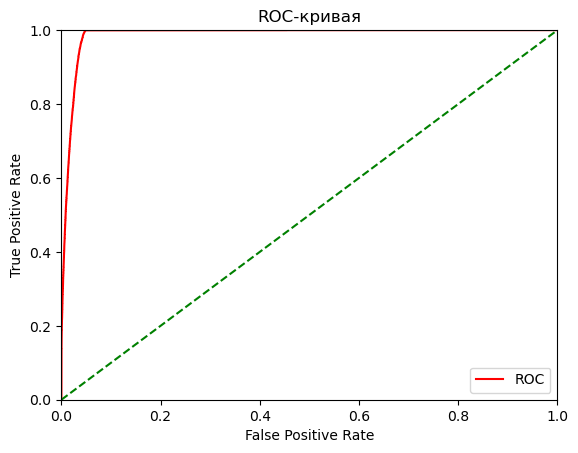

In [62]:
# отрисовываем ROC-кривую
fper, tper, thresholds = roc_curve(y_test, prediction_proba)
plot_roc_curve(fper, tper)

In [63]:
# функция построения тепловой карты для матрицы ошибок
def plot_confusion_matrix(confusion_matrix, title="Confusion Matrix"):
    """Функция принимает на вход матрицу ошибок предсказаний модели
    и строит тепловую карту по ней с указанием названия и количества ошибок,
    процентного соотношения.
    """
    plt.figure(figsize=(5, 4))

    # устанавливаем имена и формат значений, которые будут отображаться в полях
    classes = ["True Negative", "False Positive", "False Negative", "True Positive"]
    values = ["{0:0.0f}".format(x) for x in confusion_matrix.flatten()]
    percentages = [
        "{0:.1%}".format(x)
        for x in confusion_matrix.flatten() / np.sum(confusion_matrix)
    ]

    # объединяем classes, values и percentages в одну запись
    combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
    combined = np.asarray(combined).reshape(2, 2)

    # создаем и настраиваем подписи к графику
    matrix = sns.heatmap(confusion_matrix, annot=combined, fmt="", cmap="YlGnBu")
    matrix.set(title=f"{title}")

    plt.show()

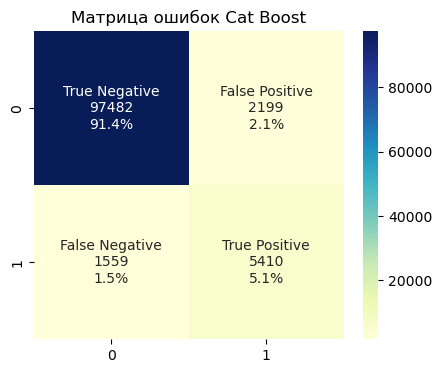

In [64]:
# строим матрицу ошибок предсказаний модели Cat Boost
plot_confusion_matrix(confusion_matrix_cat_boost, title="Матрица ошибок Cat Boost")

# Модель верно классифицировала более 95% от общего количества предсказаний!!!!

## Это очень крутой результат!!!

### Эту модель можно использовать в проде!!! 



In [65]:
# функция для визуализации важности признаков
def show_coef(names, coef, positive=False):
    """Функция строит столбиковую диаграмму с важностью признаков,
    которая отсортирована по убыванию.
    На вход принимает названия признаков и коэффициенты их важности.
    """
    tmp_df = pd.Series(index=names, data=coef).sort_values(ascending=False)
    plt.figure(figsize=(15, 10))
    if positive:
        sns.barplot(x=abs(tmp_df.values), y=tmp_df.index)
    else:
        sns.barplot(x=tmp_df.values, y=tmp_df.index)
    plt.tight_layout
    plt.show()

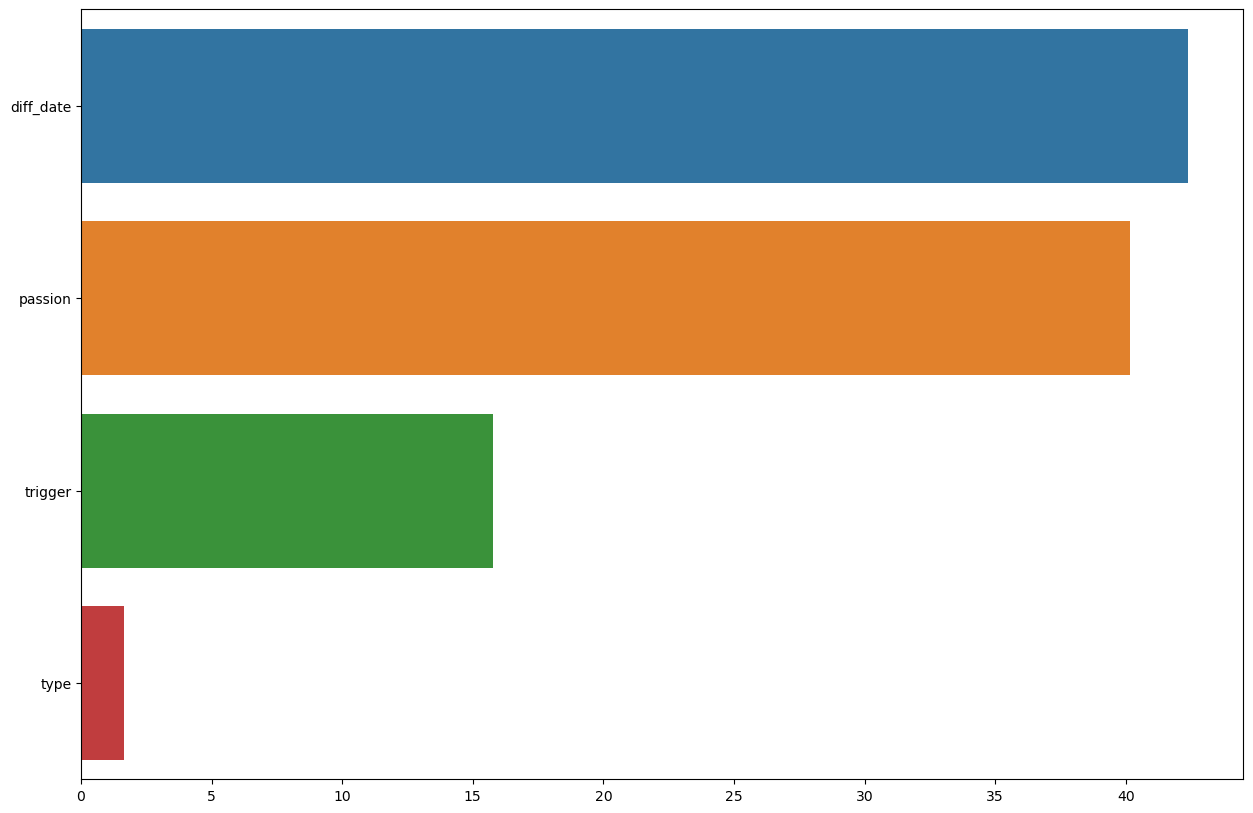

In [66]:
# строим график важности признаков
feature_names = X_train.columns.tolist()
show_coef(feature_names, feature_importances_model_cat_boos)

### Мои синтетические признаки оказались наиболее значимыми!!!!

# Общий вывод:

### В целом подобные задачи решаются примено так. Можно было бы использовать несколько моделей либо полносвязную нейросеть. 

#### Эта модель оказалась довольно качественно, но она хорошо предсказывает отказ от целевого действия. Можно её улучшить и научить хорошо предсказывать целое действие. Но даже в таком состоянии модель правильно предсказывает целевое действие 5 раз из 7, что, в целом неплохо)))
